In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [8]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import networkx as nx

In [4]:
times1 = pd.read_csv(raw_dir/'times1.csv', index_col = [0])

In [5]:
times1 = (times1
.assign(predecessor_id = lambda df_: pd.to_numeric(times1['Predecessor_ID'], errors = 'coerce').fillna(0).astype(int))

)

In [23]:
def generate_fingerprint(smiles):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=1024)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol,3,1024))
    else:
        return None

In [24]:
times1['Fingerprint'] = times1['SMILES'].apply(generate_fingerprint)

[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerator
[22:12:39] DEPRECATION WARNING: please use MorganGenerat

In [159]:
times1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830 entries, 0 to 2829
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_of_metabolite     2830 non-null   int64 
 1   Level_of_generation  2830 non-null   int64 
 2   Predecessor_ID       2830 non-null   object
 3   Chemical_name        222 non-null    object
 4   SMILES               2830 non-null   object
 5   Parent               2830 non-null   object
 6   Parent_id            222 non-null    object
 7   ID                   2830 non-null   object
 8   INCHI_KEY            2820 non-null   object
 9   transformation       2608 non-null   object
 10  predecessor_id       2830 non-null   int64 
 11  Fingerprint          2820 non-null   object
dtypes: int64(3), object(9)
memory usage: 287.4+ KB


In [192]:
parent_ids = times2[times2['Parent_id'] == 'Parent']['ID'].tolist()

In [193]:
len(parent_ids)

221

In [194]:
[e for e in parent_ids if 'DTXSID6040321' in e]

[]

In [195]:
labels = {k:v for k,v in zip(llna['DTXSID'], llna['LLNA'])}

In [202]:
del labels['DTXSID6040321']

In [196]:
times2 = times1[~times1['INCHI_KEY'].isnull()]

In [197]:
metab_map = {}
for i, group in times2.groupby('Parent'):
    metab_map[i] = list(group['ID'])[1:]

In [198]:
[e for e in metab_map.keys() if 'DTXSID6040321' in e]

['DTXSID6040321']

In [201]:
del metab_map['DTXSID6040321']

In [199]:
fingerprints = {k:v for k,v in zip(times2['ID'], times2['Fingerprint'])}

In [204]:
#fingerprints['DTXSID6040321']

In [205]:
bags = []
bag_labels = []

for parent, metabolites in metab_map.items():
    # Combine parent and metabolite fingerprints into a bag
    bag = [fingerprints[parent]] + [fingerprints[met] for met in metabolites]
    bags.append(bag)
    bag_labels.append(labels[parent])

In [206]:
print(f"Generated {len(bags)} bags.")


Generated 221 bags.


In [207]:
import torch

In [246]:
from torch.utils.data import Dataset, DataLoader

class MILDataset(Dataset):
    def __init__(self, bags, labels):
        self.bags = bags
        self.labels = labels

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        try:
            bag = self.bags[idx]
            label = self.labels[idx]
            #print(f"Bag shape: {len(bag)}, Label: {label}")  # Debugging output
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise
    
        bag = torch.tensor(bag, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)  # Ensure scalar
        return bag, label


In [247]:
from torch.nn.utils.rnn import pad_sequence

# Custom collate function for DataLoader
def collate_fn(batch):
    """
    Custom collate function for the DataLoader.
    Pads bags to the maximum number of instances in the batch.
    """
    bags, labels = zip(*batch)  # Separate bags and labels
    bags = [bag.clone().detach() if isinstance(bag, torch.Tensor) else torch.tensor(bag, dtype=torch.float32) for bag in bags]
    labels = torch.tensor(labels, dtype=torch.float32)
    
    # Pad bags
    padded_bags = pad_sequence(bags, batch_first=True)  # Shape: (batch_size, max_instances, feature_dim)
    return padded_bags, labels

In [248]:
dataset = MILDataset(bags, bag_labels)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True,collate_fn=collate_fn)

In [249]:
bag, label = dataset[0]

In [250]:
bag, label

(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(1.))

In [251]:
print("Type of bags:", type(dataset.bags))

# Check the content of `self.bags`
print("Example bag:", dataset.bags[0])  # First item
print("Length of bags:", len(dataset.bags))  # 

Type of bags: <class 'list'>
Example bag: [array([0, 0, 1, ..., 0, 0, 0]), array([0, 0, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
Length of bags: 221


In [252]:
for batch_bags, batch_labels in data_loader:
    print("Batch Bags:", batch_bags)  # Shape: (batch_size, max_instances, fingerprint_dim)
    print("Batch Labels:", batch_labels)  # Shape: (batch_size,)
    break

Batch Bags: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Batch Labels: tensor([1., 1.])


In [253]:
import torch
import torch.nn as nn

In [254]:
import torch
import torch.nn as nn


class MILModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(MILModel, self).__init__()
        self.instance_encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )
        self.aggregator = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),  # For binary classification
            nn.Sigmoid()  # Output probability
        )

    def forward(self, bag):
        # Encode instances
        instance_embeddings = self.instance_encoder(bag)  # (batch_size, max_instances, embedding_dim)
        
        # Apply mask if provided
        #if mask is not None:
        #    instance_embeddings = instance_embeddings * mask.unsqueeze(-1)  # Mask padded embeddings
        
        # Aggregate embeddings (mean pooling)
        bag_embedding = instance_embeddings.mean(dim=1)  # (batch_size, embedding_dim)
        
        # Classify using bag-level embedding
        output = self.aggregator(bag_embedding)
        return output, bag_embedding  # Squeeze for shape (batch_size)

In [255]:
model = MILModel(input_dim = 1024,embedding_dim = 128)

In [257]:
def train(model, dataloader):
    model.train()
    total_loss = 0
    for bags, labels in dataloader:
        #print(bags, label)
        # Generate mask for padded instances
        #mask = (bags.sum(dim=-1) != 0).float()  # Shape: (batch_size, max_instances)

        # Forward pass
        optimizer.zero_grad()
        outputs, embed = model(bags)
        outputs = outputs.squeeze(1) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [258]:
training = train(model, data_loader)

In [264]:
def test(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    embeddings = []  # To store embeddings if needed
    
    with torch.no_grad():
        for bags, labels in dataloader:
            outputs, embed = model(bags)  # Outputs and embeddings
            predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            
            correct += (predictions == labels.unsqueeze(1)).sum().item()  # Count correct predictions
            total += labels.size(0)
            
            embeddings.append(embed)  # Collect embeddings if needed

    accuracy = correct / total  # Calculate accuracy
    embeddings = torch.cat(embeddings, dim=0)  # Combine all embeddings
    return accuracy, correct, total, embeddings

In [265]:
# Hyperparameters
input_dim = 1024  # Fingerprint size
embedding_dim = 128
lr = 0.001
epochs = 10
batch_size = 2

# Device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, and loss function
model = MILModel(input_dim, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for classification


# Training Loop
for epoch in range(epochs):
    train_loss = train(model, data_loader)
    test_accuracy, _, _,embed = test(model, data_loader)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10, Loss: 0.6477, Test Accuracy: 0.6471
Epoch 2/10, Loss: 0.4146, Test Accuracy: 0.9095
Epoch 3/10, Loss: 0.2141, Test Accuracy: 0.9683
Epoch 4/10, Loss: 0.1157, Test Accuracy: 0.9819
Epoch 5/10, Loss: 0.0594, Test Accuracy: 0.9864
Epoch 6/10, Loss: 0.0527, Test Accuracy: 0.9955
Epoch 7/10, Loss: 0.0327, Test Accuracy: 0.9955
Epoch 8/10, Loss: 0.0632, Test Accuracy: 0.9864
Epoch 9/10, Loss: 0.0213, Test Accuracy: 0.9955
Epoch 10/10, Loss: 0.0132, Test Accuracy: 1.0000


In [267]:
bag_embeddings = np.vstack(embed)

In [269]:

from scipy.spatial.distance import pdist, squareform

In [278]:
mil_df = pd.DataFrame(squareform(pdist(bag_embeddings, 'cosine')), index = parent_ids, columns = parent_ids)

<Axes: >

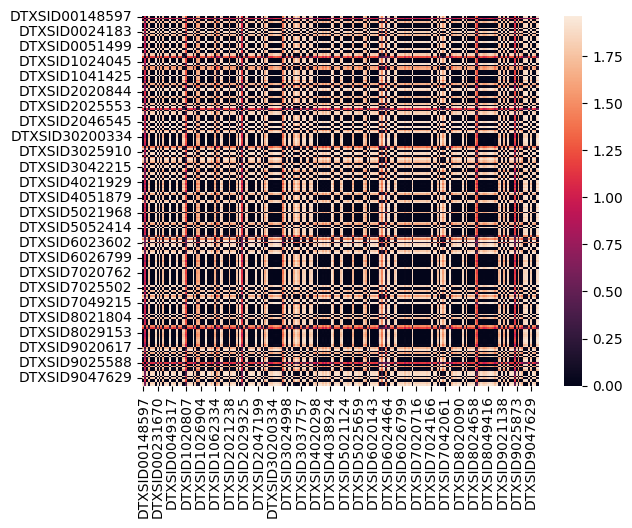

In [281]:
sns.heatmap(mil_df)

In [274]:
llna['rxn']

0                MA
1                SB
2                MA
3                MA
4              Acyl
           ...     
217              MA
218       MA_or_SN1
219              SB
220    non-reactive
221    non-reactive
Name: rxn, Length: 222, dtype: object

In [275]:
rxn_domains = {k: group['DTXSID'].tolist() for k, group in llna.groupby('rxn') if len(group['DTXSID'].tolist()) >5}


In [277]:
rxn_domains.keys()

dict_keys(['Acyl', 'MA', 'SB', 'SN2', 'SNAR', 'non-reactive', 'pre', 'pre-MA', 'pro-MA'])

In [289]:
mil_df.loc[['DTXSID4026684','DTXSID1024835','DTXSID4025587' ], ['DTXSID4026684','DTXSID1024835','DTXSID4025587' ]]

,DTXSID4026684,DTXSID1024835,DTXSID4025587
DTXSID4026684,0.000000,0.021195,0.032810
DTXSID1024835,0.021195,0.000000,0.005738
DTXSID4025587,0.032810,0.005738,0.000000


In [297]:
mil_df.loc[['DTXSID3049413','DTXSID3060372', ], ['DTXSID3049413','DTXSID3060372', ]]

,DTXSID3049413,DTXSID3060372
DTXSID3049413,0.000000,0.024866
DTXSID3060372,0.024866,0.000000


<Axes: >

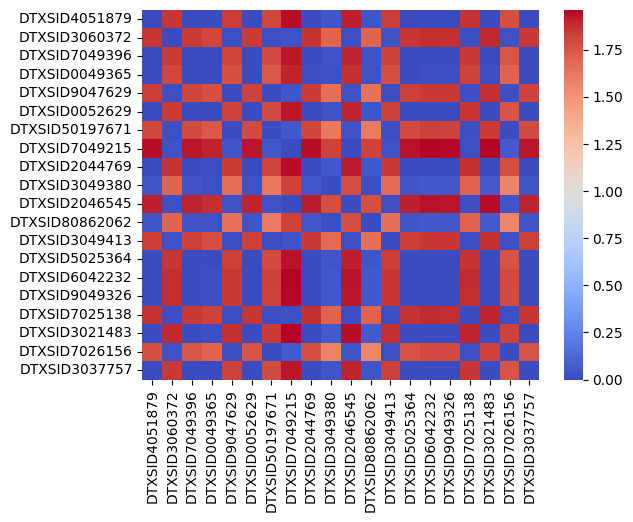

In [293]:
sns.heatmap(mil_df.loc[rxn_domains['SB'], rxn_domains['SB']], cmap = 'coolwarm')

In [294]:
llna[llna['rxn'] =='SB'].head()

,DTXSID,CASRN,SMILES,reaction_chemistry_domain,LLNA,DPRA,KeratinoSens,hCLAT,rxn
1,DTXSID4051879,2277-19-2,CC\C=C/CCCCC=O,SB,1,0.0,1,NaN,SB
25,DTXSID3060372,579-07-7,CC(=O)C(=O)C1=CC=CC=C1,SB,1,1.0,1,1.0,SB
26,DTXSID7049396,1118-71-4,CC(C)(C)C(=O)CC(=O)C(C)(C)C,SB,1,0.0,0,NaN,SB
35,DTXSID0049365,874-23-7,CC(=O)C1CCCCC1=O,SB,0,1.0,1,1.0,SB
49,DTXSID9047629,110-41-8,CCCCCCCCCC(C)C=O,SB,1,1.0,1,NaN,SB
